
# CausalPilot: A Comprehensive Tutorial

This notebook provides a complete guide to using the CausalPilot framework for causal inference in Python. We'll cover:

1. Setting up the framework
2. Loading and exploring datasets
3. Creating causal graphs
4. Estimating causal effects with multiple methods
5. Comparing estimator performance
6. Visualizing results

By the end of this tutorial, you'll have a thorough understanding of how to use CausalPilot for your own causal inference tasks.

## What is CausalPilot?

CausalPilot is a comprehensive Python framework for causal inference that integrates multiple estimation methods, causal graph modeling, and visualization tools. It provides a unified API for both causal discovery and treatment effect estimation, making it easier to conduct rigorous causal analyses.



## 1. Setup and Installation

To use CausalPilot, you first need to install it and import the necessary modules.


In [1]:

# Install CausalPilot (if you haven't already)
# !pip install causalpilot

# Uncomment the line above to install the package
# For this tutorial; we'll assume it's already installed


In [2]:

# Import main modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Import CausalPilot modules
import causalpilot as cp
from causalpilot.core import CausalGraph, CausalModel
from causalpilot.inference import DoubleML, CausalForest, TLearner, SLearner
from causalpilot.visualization import plot_causal_graph

# Set random seed for reproducibility
np.random.seed(42)

# Configure plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)



## 2. Dataset Loading and Exploration

CausalPilot includes several benchmark datasets commonly used in causal inference research. Let's explore these datasets and understand their structure.

### 2.1 IHDP Dataset (Infant Health and Development Program)

The IHDP dataset is derived from a randomized experiment evaluating the effect of home visits by specialist doctors on children's cognitive test scores. This semi-synthetic dataset is widely used in causal inference research.


In [3]:

# Load the IHDP dataset
from causalpilot.datasets import load_ihdp

ihdp_data = load_ihdp()

# Display the first few rows
print("IHDP Dataset Preview:")
print(f"Shape: {ihdp_data.shape}")
ihdp_data.head()


Loading IHDP data from cache: C:\Users\Bene User\.causalpilot\data\ihdp_npci.csv
IHDP Dataset Preview:
Shape: (747, 11)


,mother_white,mother_black,mother_hispanic,mother_married,child_male,high_school,birth_weight,gestational_age,mother_age,treatment,outcome
0,1,0,0,1,1,1,2500.000000,32.464350,32.728454,1,116.978646
1,0,1,0,1,1,1,2500.000000,40.478143,25.087054,1,111.054739
2,0,0,0,0,0,0,2500.000000,39.919305,17.583185,0,118.896833
3,1,0,0,0,1,0,1931.318356,34.662722,32.526030,1,103.349236
4,1,0,0,1,1,1,2465.679461,37.609708,29.386004,1,123.437768


In [4]:

# Explore the IHDP dataset
print("IHDP Dataset Summary:")
print(f"Number of observations: {len(ihdp_data)}")
print(f"Treatment variable: 'treatment' (binary)")
print(f"Outcome variable: 'outcome'")
print(f"Number of covariates: {len(ihdp_data.columns) - 2}")

# Distribution of treatment
print(f"\nTreatment distribution:")
print(ihdp_data['treatment'].value_counts(normalize=True))

# Basic statistics of outcome by treatment group
print(f"\nOutcome by treatment group:")
ihdp_data.groupby('treatment')['outcome'].describe()


IHDP Dataset Summary:
Number of observations: 747
Treatment variable: 'treatment' (binary)
Outcome variable: 'outcome'
Number of covariates: 9

Treatment distribution:
treatment
1    0.910308
0    0.089692
Name: proportion, dtype: float64

Outcome by treatment group:


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,67.0,112.437278,7.859704,96.306527,105.926026,113.802136,117.544355,129.213515
1,680.0,119.007458,6.815955,96.548536,114.524708,119.726842,123.579670,134.484852



### 2.2 LaLonde Dataset

The LaLonde dataset comes from a study on the effectiveness of job training programs on future earnings. It's a classic dataset in causal inference and econometrics.


In [5]:

# Load the LaLonde dataset
from causalpilot.datasets import load_lalonde

lalonde_data = load_lalonde()

# Display basic information
print("LaLonde Dataset Preview:")
print(f"Shape: {lalonde_data.shape}")
lalonde_data.head()


Loading LaLonde data from cache: C:\Users\Bene User\.causalpilot\data\lalonde_nsw.csv
LaLonde Dataset Preview:
Shape: (445, 10)


,age,education,black,hispanic,married,nodegree,re74,re75,re78,treatment
0,40.101157,12.821865,1,0,0,1,1687.813478,1831.401414,10010.608552,1
1,20.759996,9.802824,0,1,1,1,3080.064936,2854.408233,6167.109162,0
2,30.194668,10.037699,1,0,1,1,1116.361612,1030.753523,6865.838759,0
3,27.095048,11.416429,1,0,0,1,1118.070618,2625.704177,0.000000,0
4,34.112189,10.466432,1,0,0,1,4871.842026,4179.689814,3040.103574,1



### 2.3 Twins Dataset

The Twins dataset leverages twin births as a natural experiment. It uses the heavier twin as the "treated" unit and the lighter twin as the "control" unit, providing natural counterfactuals.


In [6]:

# Load the Twins dataset
from causalpilot.datasets import load_twins

twins_data = load_twins()

# Display basic information
print("Twins Dataset Preview:")
print(f"Shape: {twins_data.shape}")
twins_data.head()


Loading Twins data from cache: C:\Users\Bene User\.causalpilot\data\twins.csv
Twins Dataset Preview:
Shape: (10000, 12)


,family_id,married,black,hispanic,hs_education,mother_age,gestation_weeks,weight_diff,twin_id,birth_weight,treatment,mortality
0,0,1,0,0,1,22.177181,40.776594,506.305166,1,2427.480761,1,0
1,0,1,0,0,1,22.177181,40.776594,506.305166,2,1921.175596,0,0
2,1,0,0,0,1,30.515951,32.030228,192.903023,1,1857.279766,1,0
3,1,0,0,0,1,30.515951,32.030228,192.903023,2,1664.376743,0,0
4,2,0,1,0,1,34.837683,31.740427,261.159276,1,1505.856955,1,0



## 3. Causal Graph Construction

Causal graphs (directed acyclic graphs or DAGs) represent our assumptions about the data-generating process. CausalPilot provides tools to create and analyze these graphs.

Let's create a causal graph for the IHDP dataset:


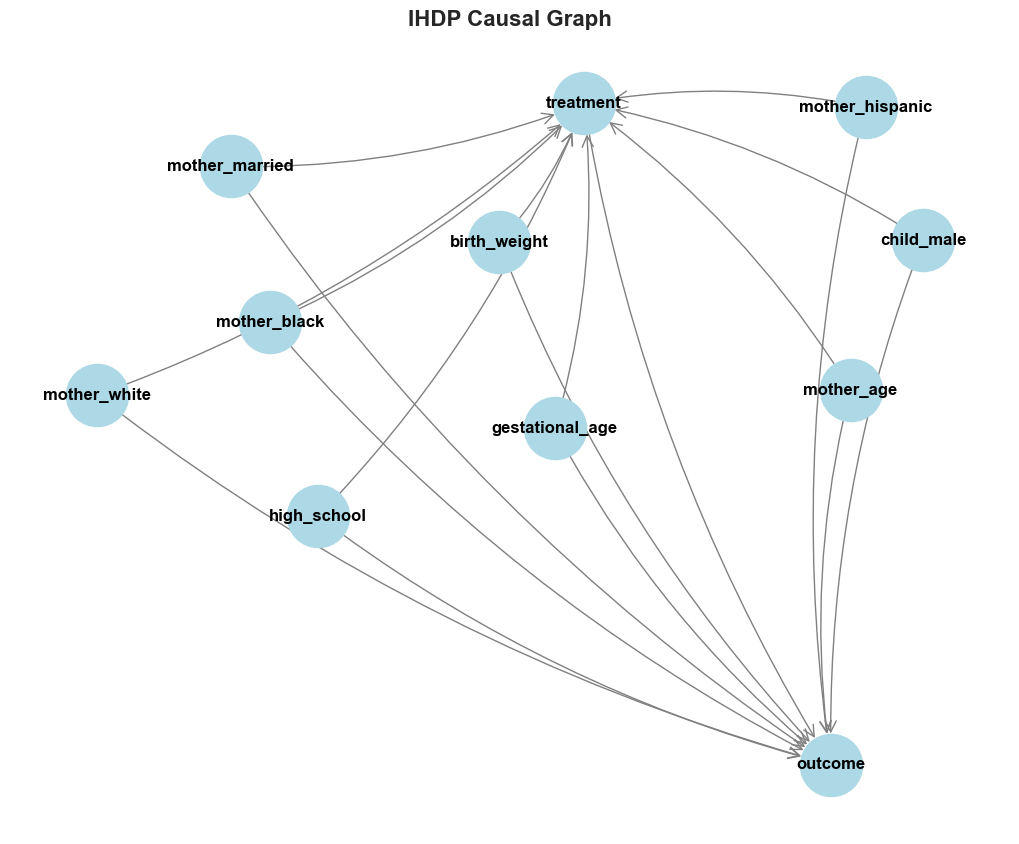

In [7]:

# Create a causal graph for the IHDP dataset
graph = cp.CausalGraph()

# Add nodes for all variables
covariates = [col for col in ihdp_data.columns if col not in ['treatment', 'outcome']]
graph.add_nodes(['treatment', 'outcome'] + covariates)

# Add edges based on domain knowledge
# Covariates -> Treatment
for covariate in covariates:
    graph.add_edge(covariate, 'treatment')

# Covariates -> Outcome
for covariate in covariates:
    graph.add_edge(covariate, 'outcome')

# Treatment -> Outcome (the causal effect we want to estimate)
graph.add_edge('treatment', 'outcome')

# Visualize the graph
cp.plot_causal_graph(graph, title="IHDP Causal Graph")



### 3.1 Identifying the Adjustment Set

Once we have a causal graph, we can identify the variables we need to adjust for (the adjustment set) to estimate the causal effect of treatment on outcome.


In [8]:

# Create a causal model
model = cp.CausalModel(
    data=ihdp_data,
    treatment='treatment',
    outcome='outcome',
    graph=graph
)

# Identify the adjustment set
adjustment_set = model.identify_effect()
print(f"Identified adjustment set: {adjustment_set}")


Identified adjustment set: ['mother_white', 'mother_black', 'mother_hispanic', 'mother_married', 'child_male', 'high_school', 'birth_weight', 'gestational_age', 'mother_age']



## 4. Single Estimator Examples

CausalPilot includes several estimators for causal effect estimation. Let's explore each of them.

### 4.1 Double/Debiased Machine Learning (DoubleML)

DoubleML uses cross-fitting to estimate nuisance functions and provides asymptotically normal and unbiased estimates of treatment effects.


In [9]:

# Use DoubleML estimator
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Extract covariates, treatment, and outcome
X = ihdp_data[adjustment_set]
T = ihdp_data['treatment']
Y = ihdp_data['outcome']

# Initialize and fit DoubleML (passing instances instead of classes)
doubleml = cp.DoubleML(
    ml_l=RandomForestRegressor(n_estimators=100, random_state=42),
    ml_m=RandomForestClassifier(n_estimators=100, random_state=42),
    n_folds=5
)

doubleml.fit(X, T, Y)

# Estimate the treatment effect
effect = doubleml.estimate_effect()
print(f"Estimated average treatment effect (DoubleML): {effect:.4f}")

# Get standard error and confidence interval
se = doubleml.standard_error_calculation()
ci = doubleml.confidence_interval()
print(f"Standard error: {se:.4f}")
print(f"95% Confidence interval: [{ci['lower']:.4f}, {ci['upper']:.4f}]")


Estimated average treatment effect (DoubleML): 1.3432
Standard error: 0.0009
95% Confidence interval: [1.3414, 1.3450]



### 4.2 Causal Forest

Causal Forest is designed to estimate heterogeneous treatment effects. It uses the forest structure to identify subgroups with different treatment effects. This method is particularly useful when you suspect that the treatment effect varies across individuals or subgroups defined by covariates.


Estimated average treatment effect (Causal Forest): 2.0888
Standard deviation of individual effects: 1.3298


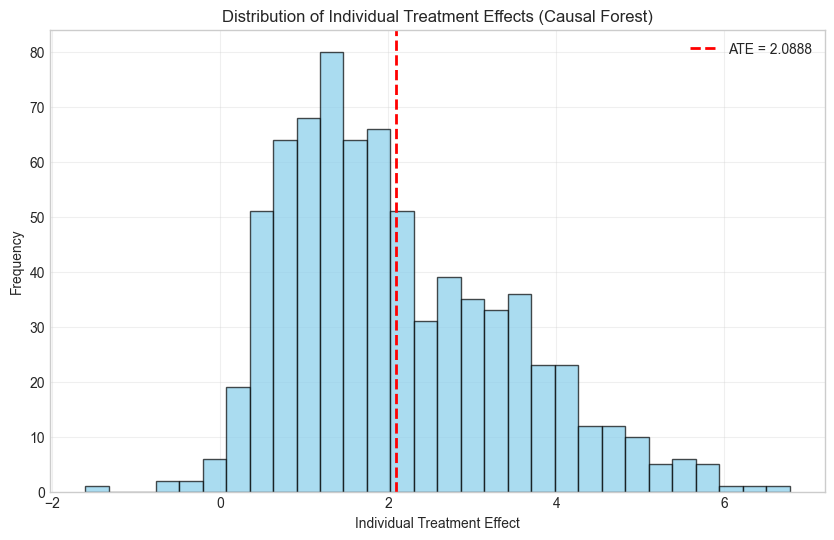

In [10]:

# Causal Forest example
from sklearn.ensemble import RandomForestRegressor

causal_forest = cp.CausalForest(
    n_trees=100,
    honest=True,
    random_state=42
)

causal_forest.fit(X, T, Y)
cf_ite = causal_forest.predict(X)
cf_ate = causal_forest.estimate_effect()

print(f"Estimated average treatment effect (Causal Forest): {cf_ate:.4f}")
print(f"Standard deviation of individual effects: {np.std(cf_ite):.4f}")

# Visualize the distribution of individual treatment effects
plt.figure(figsize=(10, 6))
plt.hist(cf_ite, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(cf_ate, color='red', linestyle='--', linewidth=2, label=f'ATE = {cf_ate:.4f}')
plt.xlabel('Individual Treatment Effect')
plt.ylabel('Frequency')
plt.title('Distribution of Individual Treatment Effects (Causal Forest)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



### 4.3 Meta-Learners (T-Learner and S-Learner)

Meta-learners use standard supervised learning methods to estimate treatment effects. CausalPilot includes two types:

1. **T-Learner**: Trains separate models for treated and control groups.
2. **S-Learner**: Trains a single model with treatment as a feature.


In [11]:

# T-Learner example
t_learner = cp.TLearner(
    base_estimator=RandomForestRegressor(n_estimators=100, random_state=42)
)

t_learner.fit(X, T, Y)
ite_t = t_learner.predict(X)
ate_t = t_learner.estimate_effect()

print(f"Estimated average treatment effect (T-Learner): {ate_t:.4f}")
print(f"Standard deviation of individual effects: {np.std(ite_t):.4f}")


Estimated average treatment effect (T-Learner): 4.5186
Standard deviation of individual effects: 4.6397


In [12]:

# S-Learner example
s_learner = cp.SLearner(
    base_estimator=RandomForestRegressor(n_estimators=100, random_state=42)
)

s_learner.fit(X, T, Y)
ite_s = s_learner.predict(X)
ate_s = s_learner.estimate_effect()

print(f"Estimated average treatment effect (S-Learner): {ate_s:.4f}")
print(f"Standard deviation of individual effects: {np.std(ite_s):.4f}")


Estimated average treatment effect (S-Learner): 3.5911
Standard deviation of individual effects: 3.0529



## 5. Comparing Multiple Estimators

CausalPilot makes it easy to compare different causal inference methods on the same dataset.


In [13]:

# Compare multiple estimators
from causalpilot.inference.comparison import compare_estimators

# Define methods to compare
methods = ['doubleml', 'causal_forest', 't_learner', 's_learner']

# Run comparison
results = compare_estimators(X, T, Y, methods=methods)

# Create a summary table
methods_data = []
for method, result in results.items():
    if 'error' not in result:
        methods_data.append({
            'Method': method,
            'ATE': result['ate'],
            'Runtime (s)': result['runtime_seconds'],
            'Effect Std': result.get('effect_std', np.nan)
        })

summary_df = pd.DataFrame(methods_data)
summary_df.sort_values('Method')


Running doubleml...
Running causal_forest...
Running t_learner...
Running s_learner...


,Method,ATE,Runtime (s),Effect Std
1,causal_forest,2.088787,16.697798,1.329830e+00
0,doubleml,1.343161,2.307936,2.220446e-16
3,s_learner,3.591103,0.390489,3.052929e+00
2,t_learner,4.518578,0.430260,4.639704e+00


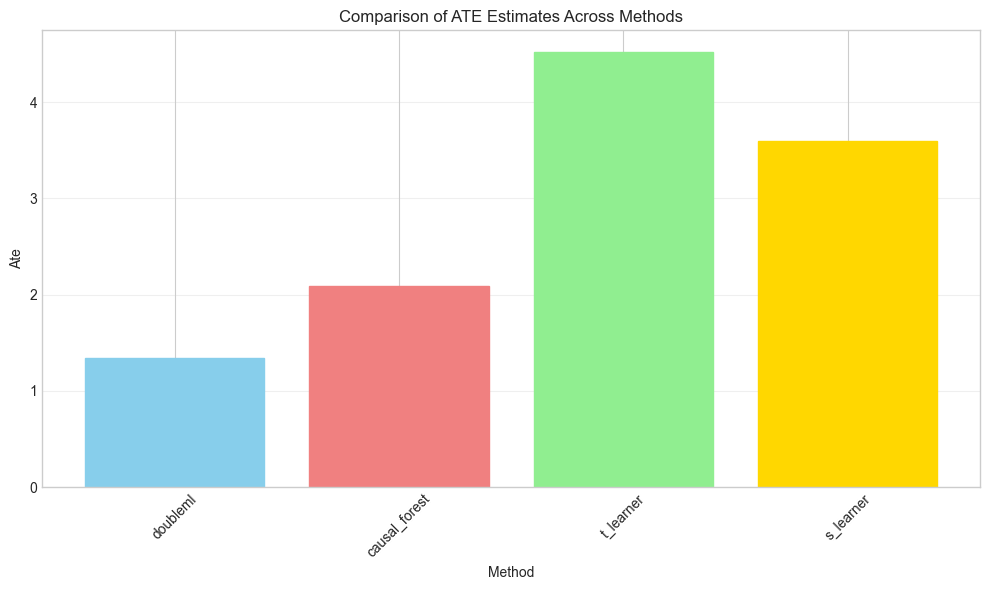

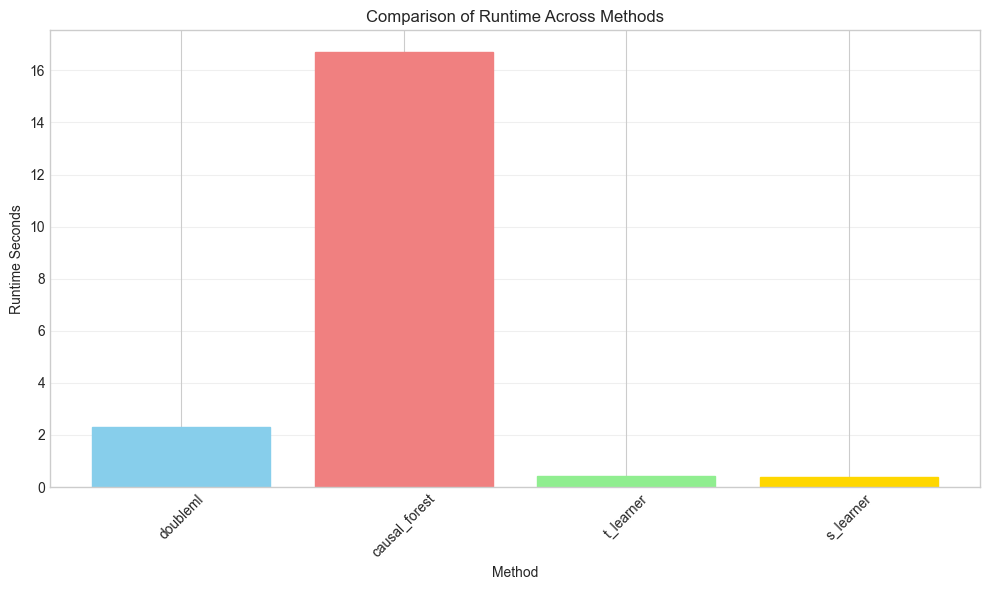

In [14]:

# Visualize comparison results
from causalpilot.inference.comparison import plot_method_comparison

plot_method_comparison(results, metric='ate', 
                       title='Comparison of ATE Estimates Across Methods')

# Also compare runtime
plot_method_comparison(results, metric='runtime_seconds', 
                       title='Comparison of Runtime Across Methods')



## 6. Heterogeneous Treatment Effects

One of the strengths of modern causal inference methods is their ability to estimate heterogeneous treatment effects. Let's explore this with Causal Forest.


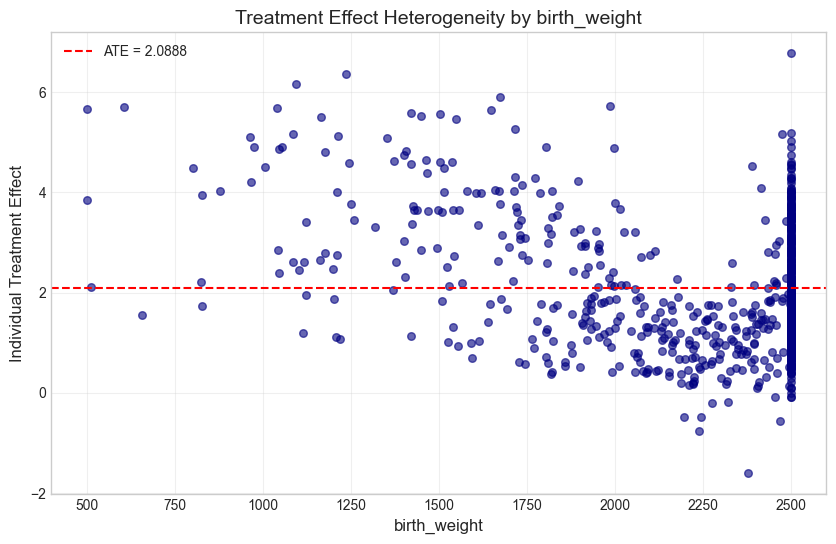

In [15]:

# Analyze treatment effect heterogeneity
if 'causal_forest' in results and 'error' not in results['causal_forest']:
    cf_estimator = results['causal_forest']['estimator']
    cf_effects = results['causal_forest']['individual_effects']

    # Choose a continuous feature
    feature_name = 'birth_weight' if 'birth_weight' in X.columns else X.columns[0]

    # Plot treatment effects against this feature
    plt.figure(figsize=(10, 6))
    plt.scatter(X[feature_name], cf_effects, alpha=0.6, s=30, color='navy')
    plt.xlabel(feature_name, fontsize=12)
    plt.ylabel('Individual Treatment Effect', fontsize=12)
    plt.title(f'Treatment Effect Heterogeneity by {feature_name}', fontsize=14)
    plt.axhline(y=results['causal_forest']['ate'], color='red', linestyle='--', 
                label=f'ATE = {results["causal_forest"]["ate"]:.4f}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()



## 7 Validating the Causal Graph and Data

Before estimating causal effects, it's important to validate your causal graph and dataset. CausalPilot provides utilities to check for common issues such as missing variables, graph cycles, and positivity violations.


In [16]:

# Validate the causal graph
from causalpilot.utils.validation import validate_graph, validate_data

graph_validation = validate_graph(graph)
print("Causal Graph Validation:")
print(graph_validation)

# Validate the dataset
validation = validate_data(ihdp_data, 'treatment', 'outcome', adjustment_set)
print("\nData Validation:")
print(validation)


Causal Graph Validation:
{'valid': True, 'warnings': [], 'errors': []}

Data Validation:
{'valid': True, 'warnings': [], 'errors': [], 'treatment_type': True}



## 8. Exporting Results and Plots

You can easily export your results and plots for reporting or further analysis. Here is how you can save a DataFrame and a plot:


Summary table saved as 'causalpilot_estimator_comparison.csv'.
Plot saved as 'causalpilot_cf_effects_hist.png'.


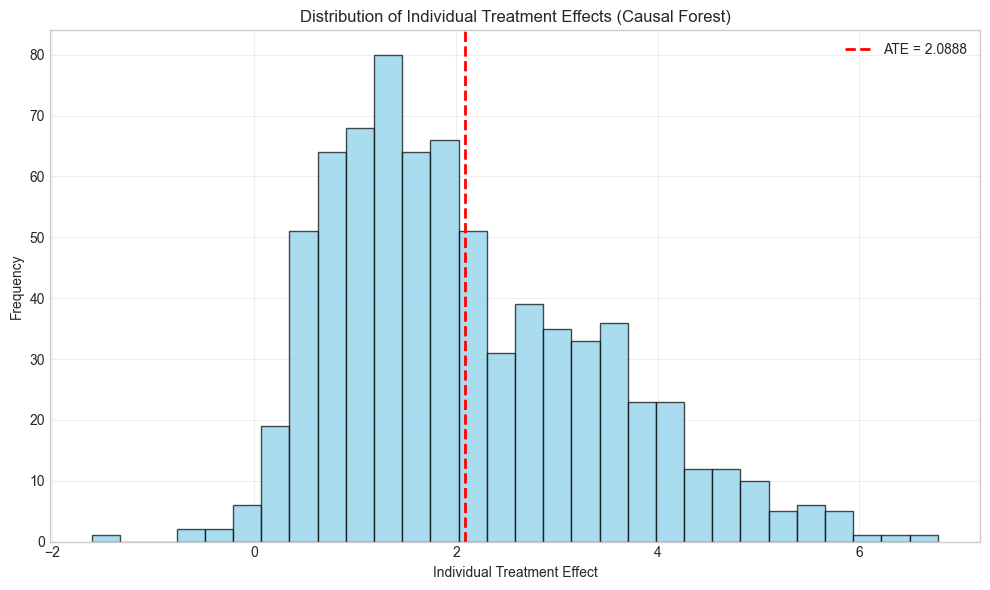

In [17]:

# Export summary table to CSV
summary_df.to_csv('causalpilot_estimator_comparison.csv', index=False)
print("Summary table saved as 'causalpilot_estimator_comparison.csv'.")

# Save a plot (e.g., the last histogram)
plt.figure(figsize=(10, 6))
plt.hist(cf_ite, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(cf_ate, color='red', linestyle='--', linewidth=2, label=f'ATE = {cf_ate:.4f}')
plt.xlabel('Individual Treatment Effect')
plt.ylabel('Frequency')
plt.title('Distribution of Individual Treatment Effects (Causal Forest)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('causalpilot_cf_effects_hist.png', dpi=300)
print("Plot saved as 'causalpilot_cf_effects_hist.png'.")



## 9. Troubleshooting and FAQ

**Q: My adjustment set is empty or missing important variables. What should I do?**
- Check your causal graph for missing edges or nodes. Make sure all confounders are included.

**Q: I get an error about missing dependencies.**
- Ensure all required packages are installed. See the requirements.txt or install with pip install causalpilot[all].

**Q: My estimator returns NaN or extreme values.**
- Check for missing data, outliers, or violations of positivity (overlap) in your dataset.

**Q: How do I interpret the ATE and ITE results?**
- The ATE (Average Treatment Effect) is the mean effect of treatment across all individuals. ITEs (Individual Treatment Effects) show how the effect varies for each individual. Large variation in ITEs suggests treatment effect heterogeneity.

**Q: How can I add my own estimator?**
- Implement a class with fit, predict, and estimate_effect methods. See the advanced notebook for an example.
